# Dimensionality Reduction for Spectral Data Analysis

This notebook demonstrates various dimensionality reduction techniques for visualizing high-dimensional spectral data from plant samples subjected to different stress treatments. It explores how these methods can reveal patterns and relationships that are otherwise hidden in complex, multi-wavelength data.

## Techniques Implemented

### Principal Component Analysis (PCA)
- **2D PCA**: Reduces spectral data to two principal components while preserving 78% of variance
- **3D PCA**: Further explores the data using three components, revealing additional structure
- **Loading Analysis**: Identifies which spectral regions (wavelengths) contribute most to the separation between samples
- **Outlier Detection**: Highlights a particularly unique spectral signature from a Fusarium-treated sample

### t-Distributed Stochastic Neighbor Embedding (t-SNE)
- **2D t-SNE**: Preserves local neighborhood structures, showing clearer group separation
- **3D t-SNE**: Further enhances visualization by adding a third dimension, maintaining even better local relationships
- **Parameter Tuning**: Explores how perplexity affects the final embedding

## Comparative Analysis

The notebook compares the effectiveness of different dimensionality reduction approaches using trustworthiness scores, which measure how well local relationships in the original data are preserved. Key findings include:

- t-SNE consistently outperforms PCA in preserving local structure (higher trustworthiness scores)
- 3D embeddings preserve more information than 2D embeddings for both methods
- PCA provides interpretable loadings that reveal which spectral regions contribute most to variance
- t-SNE creates more visually intuitive clusters but lacks the interpretability of PCA

## Insights Generated

The analysis reveals several important biological insights:
1. A single Fusarium-treated plant shows an extremely unique spectral signature
2. Combined stress treatments (drought + Fusarium) produce distinct spectral responses
3. Specific NIR regions show heightened importance in distinguishing between treatment groups

These findings demonstrate how dimensionality reduction techniques can extract meaningful patterns from complex spectral data, potentially enabling early stress detection in plants through non-invasive spectral measurements.

In [1]:
# import necessary libraries
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE
from sklearn.manifold import trustworthiness
import Template

Template = Template.Template()

# import the data from all sheets of the Excel file

df0 = pd.read_excel('Datos1_InteraccionesNIR.xlsx', sheet_name=0)
df1 = pd.read_excel('Datos1_InteraccionesNIR.xlsx', sheet_name=1)
df2 = pd.read_excel('Datos1_InteraccionesNIR.xlsx', sheet_name=2)
df3 = pd.read_excel('Datos1_InteraccionesNIR.xlsx', sheet_name=3)

# Concatenate all sheets into a single DataFrame
df = pd.concat([df0, df1, df2, df3], ignore_index=True)

df0_NotFEH0 = df0[df0['Tratamiento'] != 'Fus_EH']

# Concatenate specific dataframes for analysis

df_Not0 = pd.concat([df0_NotFEH0, df1, df2, df3], ignore_index=True)


For the dataset used, the best results are achieved with **PCA** and **t-SNE**. However, the optimal method may vary depending on the specific dataset and analysis objectives. The primary technique selected is **PCA**.

### Overview of PCA
Principal Component Analysis (PCA) is a dimensionality reduction technique that:
- Identifies the directions (principal components) along which the data exhibits the most variance.
- Projects the data onto these components, reducing the number of dimensions while preserving most of the variance.

This process simplifies the dataset, facilitating visualization and analysis while retaining essential patterns and structures. Note that PCA transforms the data into a new set of features (principal components), meaning the original features are not directly recoverable.

In [2]:
# Correct PCA implementation
pca = PCA(n_components=2)

# The wavelength columns are from index 3 to the end
wavelength_data = df.iloc[:, 3:]

# Fit AND transform the data
pca_components = pca.fit_transform(wavelength_data)

# Check explained variance
explained_variance = pca.explained_variance_ratio_
print(f"Explained variance by PC1: {explained_variance[0]:.2%}")
print(f"Explained variance by PC2: {explained_variance[1]:.2%}")
print(f"Total explained variance: {explained_variance.sum():.2%}")

# Create a DataFrame with PCA results
pca_df = pd.DataFrame(
    data=pca_components,
    columns=['PC1', 'PC2']
)

# Add categorical columns for plotting
pca_df['Tratamiento'] = df['Tratamiento'].values
pca_df['Planta'] = df['Planta'].values

# Reorder columns to put Tratamiento and Planta first
pca_df = pca_df[['Tratamiento', 'Planta', 'PC1', 'PC2']]


# Use the same parameters as you did for t-SNE for fair comparison
pca_trust_score = trustworthiness(wavelength_data, pca_components, n_neighbors=30)
print(f"PCA trustworthiness score (0-1, higher is better): {pca_trust_score:.4f}")


Explained variance by PC1: 61.88%
Explained variance by PC2: 23.21%
Total explained variance: 85.09%
PCA trustworthiness score (0-1, higher is better): 0.9747


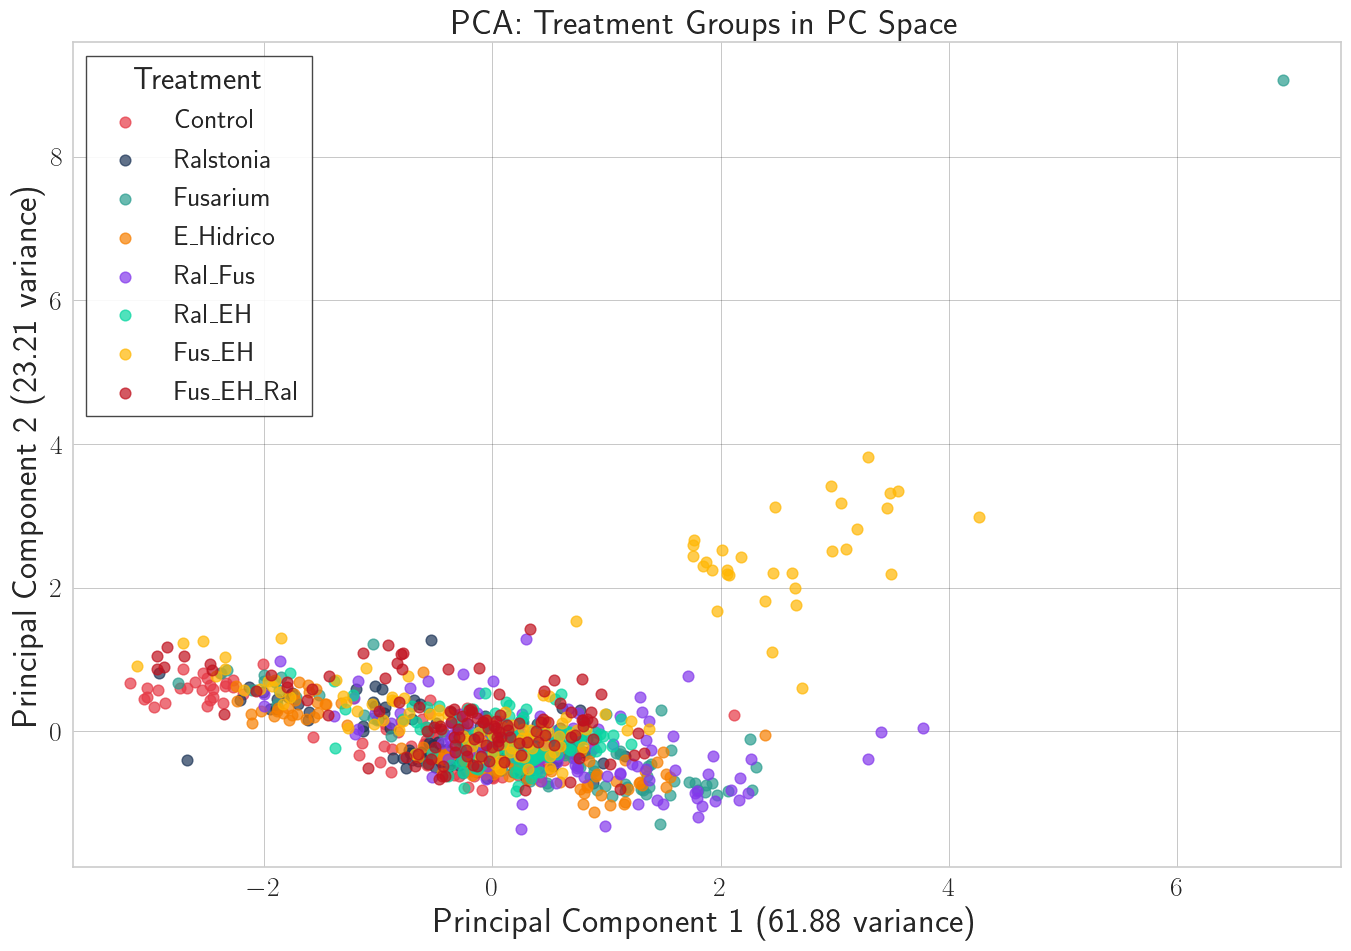

In [3]:
# Direct PCA visualization approach (without using template)
plt.figure(figsize=(14, 10))

# Plot each treatment as a separate group
for treatment in pca_df['Tratamiento'].unique():
    subset = pca_df[pca_df['Tratamiento'] == treatment]
    plt.scatter(subset['PC1'], subset['PC2'], 
                label=treatment, alpha=0.7, s=60)

# Add proper labels that reflect PCA meaning
plt.xlabel(f'Principal Component 1 (61.88 variance)')
plt.ylabel(f'Principal Component 2 (23.21 variance)')
plt.title('PCA: Treatment Groups in PC Space')
plt.legend(title='Treatment')
plt.grid(alpha=0.3)
plt.tight_layout()
plt.show()


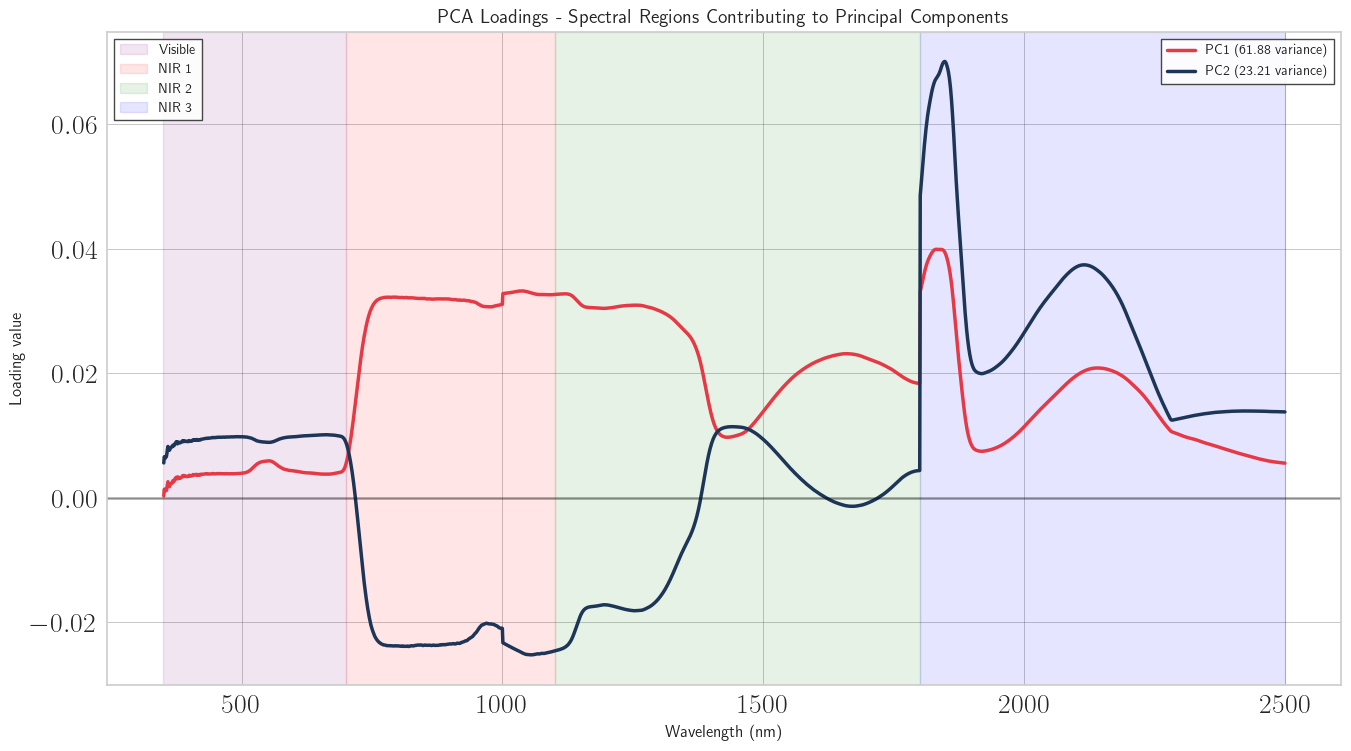

In [4]:
# Get the loadings for the first two principal components
loadings = pca.components_

# Create x-axis values (wavelengths)
wavelengths = [int(col) for col in wavelength_data.columns]

# Create a plot
fig, ax = plt.subplots(figsize=(14, 8))

# Plot loadings for PC1 and PC2
ax.plot(wavelengths, loadings[0, :], label=f'PC1 (61.88 variance)', linewidth=2.5)
ax.plot(wavelengths, loadings[1, :], label=f'PC2 (23.21 variance)', linewidth=2.5)

# Add labels and title
ax.set_xlabel('Wavelength (nm)', fontsize=12)
ax.set_ylabel('Loading value', fontsize=12)
ax.set_title('PCA Loadings - Spectral Regions Contributing to Principal Components', fontsize=14)

# Add a horizontal line at y=0 for reference
ax.axhline(y=0, color='k', linestyle='-', alpha=0.3)

# Add shaded regions for different spectral ranges
ax.axvspan(350, 700, alpha=0.1, color='purple', label='Visible')
ax.axvspan(700, 1100, alpha=0.1, color='red', label='NIR 1')
ax.axvspan(1100, 1800, alpha=0.1, color='green', label='NIR 2')
ax.axvspan(1800, 2500, alpha=0.1, color='blue', label='NIR 3')

# Create custom legends
# First legend for PC1 and PC2
handles1, labels1 = ax.get_legend_handles_labels()
leg1 = ax.legend(handles1[:2], labels1[:2], loc='upper right', fontsize=10)
ax.add_artist(leg1)

# Second legend for spectral regions
handles2, labels2 = ax.get_legend_handles_labels()
ax.legend(handles2[2:], labels2[2:], loc='upper left', fontsize=10)

# Add grid
ax.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

### Understanding PCA Outputs: `pca.components_` vs `pca.fit_transform()`

These two outputs serve **completely different purposes** in PCA analysis. Here's a detailed explanation:

---

### 1. **`pca.components_`** - The Transformation Matrix (Loadings)

#### What it is:
The **principal component vectors** that define the new coordinate system.

#### Dimensions:


In [5]:
pca.components_.shape
# Output: (n_components, n_features)
# → 2 rows (PC1, PC2) × ~2150 columns (wavelengths)

(2, 2150)



#### What it contains:
- **Each ROW** = One principal component (PC1, PC2)
- **Each COLUMN** = Weight for one original feature (wavelength)
- **Values** = How much each wavelength contributes to that PC

#### Interpretation:


In [6]:
loadings = pca.components_
print(loadings[0, 500])  # How much wavelength #500 contributes to PC1
print(loadings[1, 1000]) # How much wavelength #1000 contributes to PC2

0.032051193208525126
-0.0076217003322666945




This tells you **which features (wavelengths) are important** for each component.

---

### 2. **`pca.fit_transform()`** - The Transformed Data (Scores)

#### What it is:
Your **original data projected** onto the new principal component axes.

#### Dimensions:


In [7]:
pca_components = pca.fit_transform(wavelength_data)
pca_components.shape
# Output: (n_samples, n_components)
# → Same number of rows as original data × 2 columns (PC1, PC2)

(955, 2)



### What it contains:
- **Each ROW** = One sample (one plant measurement)
- **Each COLUMN** = The sample's coordinate along one PC
- **Values** = Where each plant sits in the reduced 2D space

### Interpretation:


In [8]:
print(pca_components[0, 0])  # Plant #0's position on PC1
print(pca_components[0, 1])  # Plant #0's position on PC2

0.01389178720882315
-0.30375042511735817




This is what you **plot as scatter points** to visualize sample relationships.

---

### Why the Dimension Difference?

#### Mathematical Relationship:

Original data:        (n_samples, n_features)  → (plants, wavelengths)

Components (weights): (n_components, n_features) → (2 PCs, wavelengths)

Transformed (scores): (n_samples, n_components) → (plants, 2 PCs)




---

## Guide to Differences

| Attribute | `pca.components_` | `pca.fit_transform()` |
|-----------|-------------------|----------------------|
| **Purpose** | How to transform data | Transformed data itself |
| **Shape** | (2, 2150+) | (N_plants, 2) |
| **Rows represent** | Principal components | Individual samples |
| **Columns represent** | Original wavelengths | Principal components |
| **Used for** | Understanding feature importance | Visualization & analysis |
| **Plotting** | Line plot (loadings vs wavelength) | Scatter plot (PC1 vs PC2) |

---

## Key Insight

- **`pca.components_`** stays the same size as your **original features** because it describes how those features combine to form PCs
- **`pca.fit_transform()`** stays the same size as your **original samples** because each sample gets a new coordinate in PC space

The number of **rows** is preserved (samples), but **columns** are reduced (from 2150 wavelengths → 2 PCs).

# Plot PCA results
we found some interesting patterns and important insights on the data:
1. This means PCA has identified it as the most spectrally unique sample in your entire dataset. It shares very little in common with any other plant, including those from other combined stress treatments, take a look at the point in the top right corner of the PCA plot, which is a plant that was exposed to Fusarium.

What does this mean for the analysis?
Theres two possiblities for this point being so far away from all other points:
- **A Measurement Error:** It's possible this is a bad measurement. The instrument could have had an error, or there might have been an issue with that specific plant sample.
- **A Truly Unique Spectral Signature:** If the measurement is accurate, this spectral signature is genuinely different from all others. This could indicate a unique physiological response to the Fusarium treatment, making it an outlier in terms of its spectral characteristics.

2. The second most unique reaction to the treatments is the plant that was exposed to both Fusarium and drought, located in the center right of the PCA plot. This plant is also quite far away from all other plants, indicating that the combined stress treatment caused a very different spectral response compared to all other treatments.

It's important to note that PCA does not directly indicate which specific wavelengths are responsible for these differences. To identify the key wavelengths, further analysis is required, such as examining the loadings of the principal components or using other feature importance techniques.



# PCA with 3 components 


In [9]:
# Correct PCA implementation
pca = PCA(n_components=3)

# The wavelength columns are from index 3 to the end
wavelength_data = df.iloc[:, 3:]

# Fit AND transform the data
pca_components_3d = pca.fit_transform(wavelength_data)

# Check explained variance
explained_variance = pca.explained_variance_ratio_
print(f"Explained variance by PC1: {explained_variance[0]:.2%}")
print(f"Explained variance by PC2: {explained_variance[1]:.2%}")
print(f"Explained variance by PC3: {explained_variance[2]:.2%}")
print(f"Total explained variance: {explained_variance.sum():.2%}")

# Create a DataFrame with PCA results
pca_df = pd.DataFrame(
    data=pca_components_3d,
    columns=['PC1', 'PC2', 'PC3']
)

# Add categorical columns for plotting
pca_df['Tratamiento'] = df['Tratamiento'].values
pca_df['Planta'] = df['Planta'].values

# Reorder columns to put Tratamiento and Planta first
pca_df = pca_df[['Tratamiento', 'Planta', 'PC1', 'PC2', 'PC3']]

Explained variance by PC1: 61.88%
Explained variance by PC2: 23.21%
Explained variance by PC3: 9.28%
Total explained variance: 94.38%


<>:34: SyntaxWarning: invalid escape sequence '\%'
<>:35: SyntaxWarning: invalid escape sequence '\%'
<>:36: SyntaxWarning: invalid escape sequence '\%'
<>:34: SyntaxWarning: invalid escape sequence '\%'
<>:35: SyntaxWarning: invalid escape sequence '\%'
<>:36: SyntaxWarning: invalid escape sequence '\%'
C:\Users\ricar\AppData\Local\Temp\ipykernel_23984\2407283009.py:34: SyntaxWarning: invalid escape sequence '\%'
  ax.set_xlabel(f'PC1 (61.88\% variance)', fontsize=20)
C:\Users\ricar\AppData\Local\Temp\ipykernel_23984\2407283009.py:35: SyntaxWarning: invalid escape sequence '\%'
  ax.set_ylabel(f'PC2 (23.21\% variance)', fontsize=20)
C:\Users\ricar\AppData\Local\Temp\ipykernel_23984\2407283009.py:36: SyntaxWarning: invalid escape sequence '\%'
  ax.set_zlabel(f'PC3 (9.28\% variance)', fontsize=20)


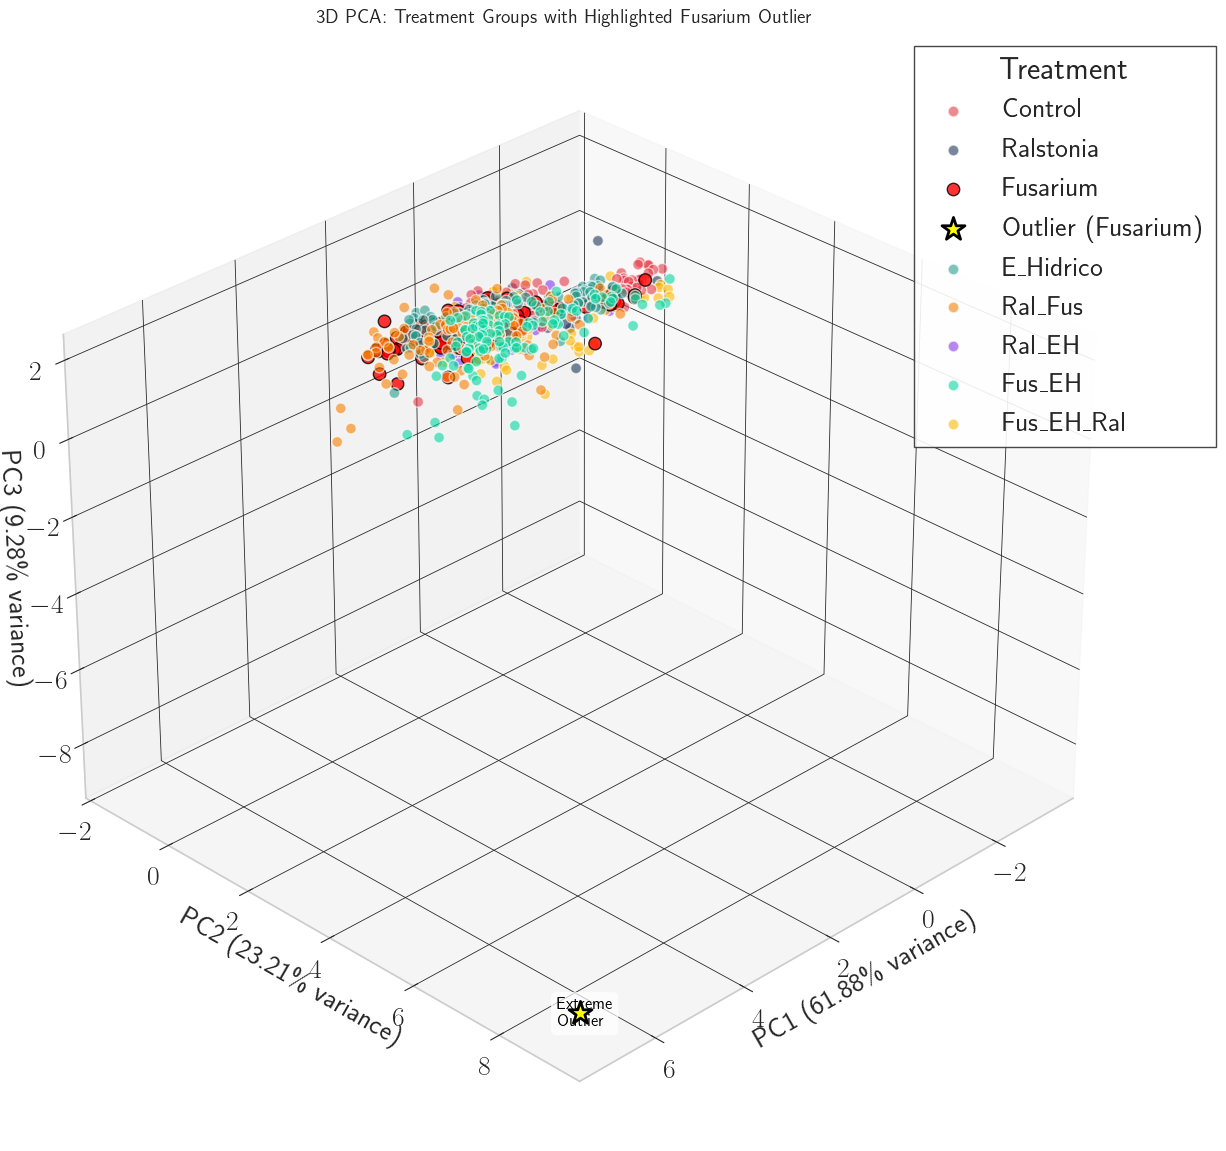

In [18]:
# Create the figure and 3D axes
fig = plt.figure(figsize=(16, 12))
ax = fig.add_subplot(111, projection='3d')

# Get unique treatments for color mapping
treatments = pca_df['Tratamiento'].unique()

# First plot all non-Fusarium treatments
for treatment in treatments:
    if 'Fusarium' not in treatment:
        subset = pca_df[pca_df['Tratamiento'] == treatment]
        ax.scatter(subset['PC1'], subset['PC2'], subset['PC3'],
                  label=treatment, alpha=0.6, s=60, edgecolor='w')

    # Now plot Fusarium treatments with special highlighting
    if 'Fusarium' in treatment:
        subset = pca_df[pca_df['Tratamiento'] == treatment]
        
        # Find the outlier point (assuming it's the one with largest PC1 value)
        outlier_idx = subset['PC1'].idxmax()
        non_outliers = subset.drop(outlier_idx)
        outlier = subset.loc[outlier_idx]
        
        # Plot regular Fusarium points with distinct color
        ax.scatter(non_outliers['PC1'], non_outliers['PC2'], non_outliers['PC3'],
                  label=treatment, color='#FF0000', alpha=0.8, s=80, edgecolor='k')
        
        # Plot outlier with special marker and size
        ax.scatter(outlier['PC1'], outlier['PC2'], outlier['PC3'],
                  marker='*', color='yellow', s=300, edgecolor='black', linewidth=2,
                  label=f'Outlier ({treatment})')

# Set axis labels with explained variance
ax.set_xlabel(f'PC1 (61.88\% variance)', fontsize=20)
ax.set_ylabel(f'PC2 (23.21\% variance)', fontsize=20)
ax.set_zlabel(f'PC3 (9.28\% variance)', fontsize=20)

# Set title and legend
ax.set_title('3D PCA: Treatment Groups with Highlighted Fusarium Outlier', fontsize=14)
ax.legend(title='Treatment', loc='upper right', bbox_to_anchor=(1.1, 1))

# Add an annotation pointing to the outlier
ax.text(outlier['PC1']+0.5, outlier['PC2'], outlier['PC3'], 
        "Extreme\nOutlier", fontsize=12, color='black',
        bbox=dict(facecolor='white', alpha=0.7, boxstyle='round'))

# Improve perspective
ax.view_init(elev=30, azim=45)
ax.dist = 12

# Add grid for better depth perception
ax.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

In [11]:
# Use the same parameters 
pca_3d_trust_score = trustworthiness(wavelength_data, pca_components_3d, n_neighbors=30)
print(f"PCA 3D trustworthiness score (0-1, higher is better): {pca_3d_trust_score:.4f}")


PCA 3D trustworthiness score (0-1, higher is better): 0.9779


### Overview of t-SNE (t-Distributed Stochastic Neighbor Embedding)

We will now apply a more advanced dimensionality reduction technique, t-SNE, to visualize the data and analyze the results.

t-SNE is a powerful non-linear technique designed specifically for visualizing high-dimensional data in a low-dimensional space, such as a 2D or 3D plot. Unlike PCA, which focuses on preserving the global variance, t-SNE's primary goal is to preserve the **local neighborhood structure** of the data. This means it tries to ensure that points that are close to each other in the original high-dimensional space remain close to each other on the new low-dimensional map.

The algorithm works in two main stages:

1.  **High-Dimensional Similarities:** First, t-SNE measures the similarity between pairs of data points in the original high-dimensional space. It models this similarity as a probability distribution, placing a Gaussian (bell curve) centered on each point and calculating the probability that other points belong to its neighborhood.

2.  **Low-Dimensional Representation:** Next, it creates a similar probability distribution for the points in a low-dimensional map (e.g., a 2D plane), but it uses a Student's t-distribution. This distribution has heavier tails, which helps to separate distinct clusters and reduce crowding in the center of the plot.

Finally, the algorithm iteratively adjusts the positions of the points on the low-dimensional map to minimize the difference (specifically, the Kullback-Leibler divergence) between the high-dimensional and low-dimensional probability distributions. The result is a map that excels at revealing the underlying cluster structure of the data.



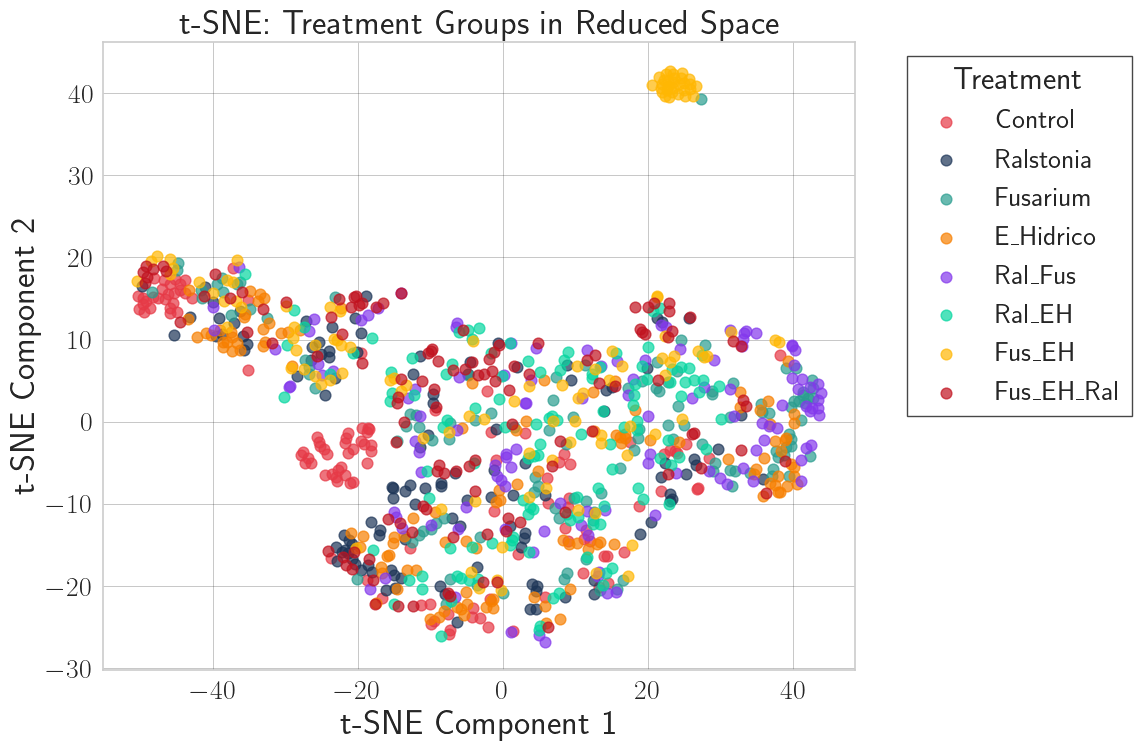

In [12]:
# The wavelength columns are from index 3 to the end
wavelength_data = df.iloc[:, 3:]

tsne = TSNE(n_components=2, perplexity=30, random_state=42)
tsne_results = tsne.fit_transform(wavelength_data)

# Create a DataFrame with t-SNE results
tsne_df = pd.DataFrame(
    data=tsne_results,
    columns=['t-SNE1', 't-SNE2']
)

# Add categorical columns for plotting
tsne_df['Tratamiento'] = df['Tratamiento'].values
tsne_df['Planta'] = df['Planta'].values

# Plot t-SNE results
plt.figure(figsize=(12, 8))

# Plot each treatment as a separate group
for treatment in tsne_df['Tratamiento'].unique():
    subset = tsne_df[tsne_df['Tratamiento'] == treatment]
    plt.scatter(subset['t-SNE1'], subset['t-SNE2'], 
                label=treatment, alpha=0.7, s=60)

plt.xlabel('t-SNE Component 1')
plt.ylabel('t-SNE Component 2')
plt.title('t-SNE: Treatment Groups in Reduced Space')
plt.legend(title='Treatment', bbox_to_anchor=(1.05, 1), loc='upper left')
plt.grid(alpha=0.3)
plt.tight_layout()
plt.show()

In [13]:
#  Kullback-Leibler Divergence (lower is better)
kl_divergence = tsne.kl_divergence_
print(f"Final KL divergence: {kl_divergence}")

# Trustworthiness and Continuity
tsne_trust_score = trustworthiness(wavelength_data, tsne_results, n_neighbors=30)
print(f"Trustworthiness score (0-1, higher is better): {tsne_trust_score:.4f}")



Final KL divergence: 0.6915559768676758
Trustworthiness score (0-1, higher is better): 0.9795


In [14]:

# Display the difference
print(f"Difference (t-SNE - PCA): {tsne_trust_score - pca_trust_score:.4f}")

Difference (t-SNE - PCA): 0.0048


### 3D t-SNE: Visualizing High-Dimensional Data in Three Dimensions
t-SNE (t-Distributed Stochastic Neighbor Embedding) in 3D works similarly to its 2D counterpart, but projects data into a three-dimensional space instead of a plane. Here's how it works:

#### How 3D t-SNE Works
1. **Similarity Calculation**: t-SNE first computes pairwise similarities between data points in the original high-dimensional space using Gaussian distributions.

2. **Probability Mapping**: These similarities are converted into conditional probabilities, representing how likely each point would pick another as its neighbor.

3. **3D Embedding Creation**: Points are initially placed randomly in 3D space, then iteratively moved to minimize the difference (Kullback-Leibler divergence) between the high-dimensional probability distribution and the low-dimensional one.

4. **t-Distribution**: In the low-dimensional space, t-SNE uses a t-distribution (rather than Gaussian) to prevent the "crowding problem" and better separate clusters.

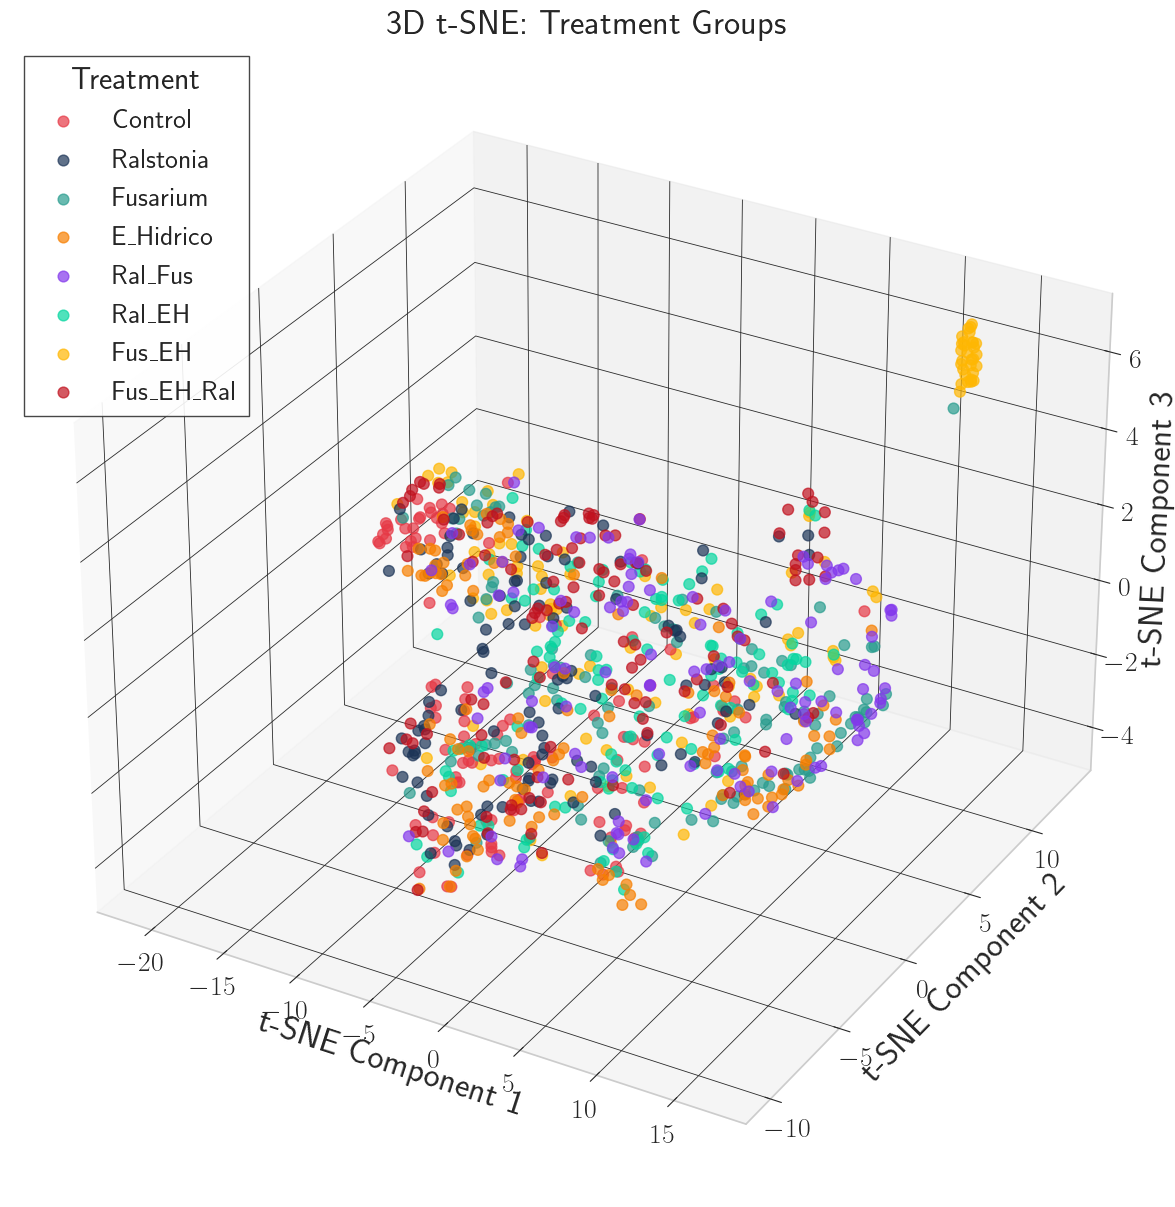

In [19]:
tsne_3d = TSNE(n_components=3, perplexity=30, random_state=42)
tsne_results_3d = tsne_3d.fit_transform(wavelength_data)

# Create 3D plot (similar to your PCA 3D visualization)
fig = plt.figure(figsize=(18, 15))
ax = fig.add_subplot(111, projection='3d')

# Plot each treatment
for treatment in tsne_df['Tratamiento'].unique():
    subset = pd.DataFrame(tsne_results_3d)[df['Tratamiento'] == treatment]
    ax.scatter(subset[0], subset[1], subset[2], 
              label=treatment, alpha=0.7, s=60)

ax.set_xlabel('t-SNE Component 1')
ax.set_ylabel('t-SNE Component 2')
ax.set_zlabel('t-SNE Component 3')
ax.set_title('3D t-SNE: Treatment Groups')
ax.legend(title='Treatment')
plt.show()

In [16]:
#  Kullback-Leibler Divergence (lower is better)
kl_divergence_3d = tsne_3d.kl_divergence_
print(f"Final KL divergence: {kl_divergence_3d}")

# Trustworthiness and Continuity
tsne_3d_trust_score = trustworthiness(wavelength_data, tsne_results_3d, n_neighbors=30)
print(f"Trustworthiness score (0-1, higher is better): {tsne_3d_trust_score:.4f}")


Final KL divergence: 0.5798578262329102
Trustworthiness score (0-1, higher is better): 0.9870


In [17]:
# Lets compare PCA 3D vs t-SNE 3D using the same metrics

# Display the difference
print(f"Difference (t-SNE - PCA): {tsne_3d_trust_score - pca_3d_trust_score:.4f}")


Difference (t-SNE - PCA): 0.0091


### **Analysis of Dimensionality Reduction Trustworthiness**

To evaluate how well each dimensionality reduction method preserved the local structure of the original high-dimensional data, we calculated their trustworthiness scores. A higher score indicates a more faithful representation of the neighborhood relationships between data points.

**Trustworthiness Scores:**
* **t-SNE 3D:** 0.9870
* **t-SNE 2D:** 0.9795
* **PCA 3D:** 0.9779
* **PCA 2D:** 0.9747

The results clearly indicate that **t-SNE is superior to PCA in preserving the local neighborhood structure**, which is its primary design goal. The **t-SNE 3D** embedding provided the most trustworthy representation, suggesting that the additional dimension allowed for a more accurate arrangement of the data points without distorting their local relationships.

While all methods performed well (with scores above 0.97), the ranking confirms that for tasks where visualizing the fine-grained clustering and separation of data points is the main objective, t-SNE is the more effective technique. PCA, by contrast, focuses on preserving global variance, which makes it better suited for feature extraction prior to a classification task, even if it slightly compromises the local structure.


### Notes on Trustworthiness Scores
Trustworthiness is used to indicate to what extent the local structure (similar to KNN) is retained.
According to the documentation the trustworthiness score is defined as: 

$$
T(k) = 1 - \frac{2}{n k (2n - 3k - 1)} \sum_{i=1}^{n} \sum_{j \in U_k(i)} (r(i,j) - k)
$$

for more information visit: https://scikit-learn.org/stable/modules/generated/sklearn.manifold.trustworthiness.html